# Working with Text Data

# 1. Introduction
There are three main ways of tokenizing text:
1. Segment text into words
2. Segment text into charaters
3. Segment text into n-grams of words or character

Once the text has been tokenized, we can convert it into vectors in one of two ways:
- one hot encoding
- word embedding
We will consider each in turn.

# 2. One-hot Encoding
We could perform one-hot encoding at the word or character level.

Here is one-hot encoding for words.

In [1]:
import os
import numpy as np
import string
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.datasets import imdb
from keras import preprocessing

from keras.models import Sequential
from keras.layers import Flatten, Dense

Using TensorFlow backend.


In [2]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}  # this is a dictionary mapping words to indices
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1  # index for the very first added word is 1
            
max_length = 10

results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

We can check the one-hot encoding for the second sample.

In [3]:
results[1, :, :]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

As the sample has only five words, only the first five rows have 1's occuring. By convention, the first column is full of zeros.

We can also one-hot encode letters.

In [4]:
characters = string.printable  # shows all printable ASCII characters
token_index = dict(zip(characters, range(1, len(characters) + 1)))  # map each ascii character to index

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1

Keras enables you to perform one-hot encoding. It has the advantage of also stripping special characters and only taking into account the $N$ most common words.

In [5]:
tokenizer = Tokenizer(num_words=1000)  # tokenizer only takes into account the 1,000 most common words
tokenizer.fit_on_texts(samples)  # builds the word index
word_index = tokenizer.word_index  # dictionary mapping word to index
print(word_index)

sequences = tokenizer.texts_to_sequences(samples)  # sequence of word_indices for each sample
print(sequences)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
print(one_hot_results[:, :20])

{'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}
[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]
[[0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


One-hot hashing avoids explicitly assigning an index to each word. Rather words are hased into vectors of fixed size. It saves memory and allows online encoding of data. However, it is possible that two words may end up with the same hash - particularly if the dimensionality is too small.

In [6]:
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality  # hashes word into random integer index between 0 and 1000
        results[i, j, index] = 1

# 3. Word Embeddings
There are two ways to embed words:
- learn embeddings jointly with the main task (e.g. document classification, sentiment prediction). Here, we start with random word vectors and update them via back propogation.
- load pretrained word embeddings

## 3.1. Learn Word Embeddings
Embeddings are a dictionary that map integer indices (which stand for various words) to dense vectors. The Embedding layer takes in a tensor of shape `(samples, sequence_length)`. We truncate longer sequences and zero-pad short sequences so all samples have the same length. The layer returns a tensor of shape `(samples, sequence_length, embedding_dimensionality)`. This tensor can be processed by an RNN or a convolutional layer.

Let us load the IMDB dataset.

In [7]:
max_features = 10000  # only consider the max_features most popular words
maxlen = 20  # cuts off texts after this number of words

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print('Example of Training Sequence')
print(x_train[0])
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print('Sequence Shortened!')
print(x_train[0])

embedding_layer = Embedding(1000, 64)  # 1st argument = # tokens, 2nd = embedding dimensions

Example of Training Sequence
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Sequence Shortened!
[  65   16 

We can now define a model with an Embedding layer.

In [8]:
model = Sequential()
# Embedding shaoe is (samples, maxlen, 8)
model.add(Embedding(10000, 8, input_length=maxlen))  # 1st argument = # possible tokens, 2nd = embedding dim
# flattening treats each word in input separately, ignoring sentence structure and inter-dependencies
model.add(Flatten())  # flatten to shape (samples, maxlen * 8)

model.add(Dense(1, activation='sigmoid'))  # add a classifier ontop the embedding layer
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


We can now fit the model to the training data.

In [9]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 43us/step - loss: 0.6727 - acc: 0.6199 - val_loss: 0.6284 - val_acc: 0.6954
Epoch 2/10
20000/20000 [==============================] - 1s 41us/step - loss: 0.5509 - acc: 0.7504 - val_loss: 0.5323 - val_acc: 0.7248
Epoch 3/10
20000/20000 [==============================] - 1s 37us/step - loss: 0.4655 - acc: 0.7882 - val_loss: 0.5042 - val_acc: 0.7442
Epoch 4/10
20000/20000 [==============================] - 1s 37us/step - loss: 0.4217 - acc: 0.8112 - val_loss: 0.4943 - val_acc: 0.7514
Epoch 5/10
20000/20000 [==============================] - 1s 36us/step - loss: 0.3911 - acc: 0.8269 - val_loss: 0.4930 - val_acc: 0.7568
Epoch 6/10
20000/20000 [==============================] - 1s 36us/step - loss: 0.3662 - acc: 0.8380 - val_loss: 0.4951 - val_acc: 0.7594
Epoch 7/10
20000/20000 [==============================] - 1s 37us/step - loss: 0.3435 - acc: 0.8511 - val_loss: 0.5027 - val_acc:

The network achieves 75% accuracy ignoring sentence structure and only using the first 20 words in a review. Imagine how high it can go if we use the entire review and add an RNN or 1D CNN layer to account for sentence structure!

## 3.2. Pretrained Word Embeddings
A pretrained embedding can capture generic aspects of language structure. It is useful when there is not much data to learn an embedding.

We shall see how to got from the raw text right through to the word embeddings.

### 3.2.1. Downloading the Raw data

We create a list `texts` to store the reviews and a list of integers `labels` to store the corresponding labels.

In [10]:
imdb_dir = '/home/d869321/Data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:]  == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

We can subsequently preview the reviews.

In [11]:
print(labels[12498:12502])
texts[12498:12502]

[0, 0, 1, 1]


["Without a doubt this is one of the worst films I've ever wasted money on! The plot is, erm sorry, did I say there was a plot? The scariest moment was when..., nope can't think of one! The best special effect that had me hiding under the bed covers was..., nope can't think of one for that either. You knew who the killer was right from the start. There was nothing scary about the whole movie, in fact the only two vaguely interesting bits were when you saw the kid sister, Misty, in the shower and when you saw Nurse Toppan take her top off. This film should only be watched to get an idea of how NOT to make a horror movie!!!",
 'this movie is outrageous. by outrageous, i mean awful. i had more fun watching the paint dry at my local hardware store on an august day while suffering from a migraine and heat stroke. the acting got progressively worse as the "movie" advanced, and the directors use of euphoric drugs became apparent as the final scenes approached. when misty was shot to death she

### 3.2.2. Tokenize the Data
To show how a pretrained embedding can be useful, we restrict the training data to just 200 examples.

We first convert each review into a sequence of integers via tokenization.

In [12]:
maxlen = 100  # cuts off reviews after 100 words
training_samples = 200
validation_samples = 10000
max_words = 10000  # consider only the 10,000 most popular words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
print('Length of sequence:', len(sequences))
print('Example of a sequence:', sequences[0])

Length of sequence: 25000
Example of a sequence: [7693, 2, 1, 4, 11, 819, 891, 20, 1, 352, 2016, 83, 1484, 31, 5674, 12, 4558, 1037, 3348, 186, 2, 12, 29, 4, 24, 408, 23, 976, 5, 27, 620, 612, 12, 328, 215, 280, 4558, 13, 52, 73, 32, 4, 1, 9878, 2, 24, 290, 4381, 13, 12, 6354, 529, 6887, 235, 560, 1, 695, 15, 1, 179, 1, 159, 2128, 97, 2232, 196, 1, 49, 2, 1, 75, 7, 7, 104, 391, 3606, 790, 1, 2306, 6, 996, 14, 3, 10, 13, 1574, 4, 3930, 8, 1, 201, 708, 1983, 244, 71, 3, 129, 2512, 5, 409, 43, 1, 4, 32, 1293, 9654, 2, 1, 804, 4, 612, 12, 2437, 692, 976, 5, 27, 620, 3022, 8, 3840, 7, 7, 29, 4, 11, 269, 37, 1656, 2130, 16, 32, 4174, 349, 5, 434, 20, 1679, 299, 60, 31, 1, 93, 23, 35, 858, 3584, 1, 2974, 5621, 1069, 3264, 4, 1, 6259, 97, 25, 221, 3, 125, 289, 4, 538, 605, 37, 764, 10, 870, 95, 5, 242, 98, 783, 101, 1, 4175, 7916, 14, 221, 31, 1, 151, 3432, 7, 7, 430, 243, 6, 1, 1927, 4, 753, 60, 1, 19, 4, 98, 279, 5, 1773, 258, 1, 1184, 4, 11, 19, 989, 1, 62, 5, 91, 6354, 997, 33, 1250, 714, 

We can see how the tokenizer maps each integer to an index.

In [13]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

word_index = tokenizer.word_index
n_items = take(20, word_index.items())
print('word_index:', n_items)
print('Found %s unique tokens.' % len(word_index))

word_index: [('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('br', 7), ('in', 8), ('it', 9), ('i', 10), ('this', 11), ('that', 12), ('was', 13), ('as', 14), ('for', 15), ('with', 16), ('movie', 17), ('but', 18), ('film', 19), ('on', 20)]
Found 88582 unique tokens.


We can also split the data into a training set and a validation set.

In [14]:
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)  # initially first half of data is negative reviews
data = data[indices]
labels = labels[indices]

# 200 data points for training and 10000 for validation
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: (training_samples + validation_samples)]
y_val = labels[training_samples: (training_samples + validation_samples)]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### 3.2.3. Using a Pretrained Embedding
We shall use the Glove Embeddings, which contain a 100D embedding vector for 400,000 words.

Let's parse the file and build an index that maps words o their vector representation.

In [15]:
glove_dir = '/home/d869321/Data/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]  # first entry in each line is the word
    coefs = np.asarray(values[1:], dtype='float32')  # ...and every subsequent entry forms 100D embedding
    embeddings_index[word] = coefs
f.close()

n_items = take(1, embeddings_index.items())
print('word embedding for "the":', n_items)
print('Found %s word vecotrs.' % len(embeddings_index))

word embedding for "the": [('the', array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  

We can use this to build an embedding matrix (size `(max_words, embedding_dim`) to load into an `Embedding` layer.

In [16]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        # note that words not found in embeddings_index will be all zeros in embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

We can now define the architecture.

In [17]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Once the model architecture is defined, we can load the GloVe matrix into the `Embedding` layer and freeze it.

In [18]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

We can compile and train the model.

In [19]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 2.1067 - acc: 0.5000 - val_loss: 0.7431 - val_acc: 0.4979
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5861 - acc: 0.6950 - val_loss: 0.6933 - val_acc: 0.5396
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 0.6164 - acc: 0.7600 - val_loss: 0.7068 - val_acc: 0.5409
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2856 - acc: 0.9400 - val_loss: 0.7106 - val_acc: 0.5510
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.3122 - acc: 0.8350 - val_loss: 0.9042 - val_acc: 0.5046
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.1821 - acc: 0.9450 - val_loss: 0.8698 - val_acc: 0.5249
Epoch 7/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0964 - acc: 0.9900 - val_loss: 0.7203 - val_acc: 0.5693
Epoch 8/10
200/200 [========

We can evaluate the model performance.

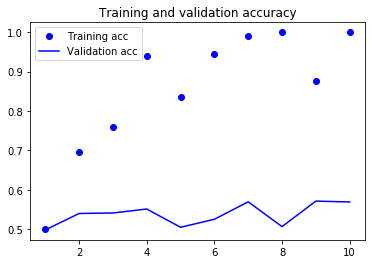

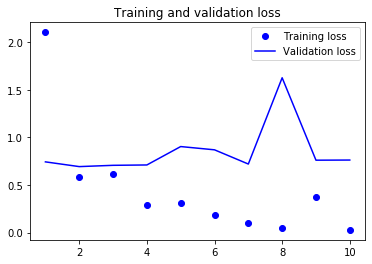

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The model overfits, which is not surprising given our sample of 200. Its accuracy is barely better than random.

What would happen if we did not use the pretrained word embedding, but rather attempted to also learn the embedding on the sample of 200?

In [21]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6945 - acc: 0.5250 - val_loss: 0.6936 - val_acc: 0.5110
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5144 - acc: 0.9700 - val_loss: 0.6924 - val_acc: 0.5151
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 0.2984 - acc: 0.9800 - val_loss: 0.6990 - val_acc: 0.5170
Epoch 4/10
200/200 [==============================] - 0s 1ms/step - loss: 0.1262 - acc: 1.0000 - val_loss: 0.7095 - val_acc: 0.5222
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0611 - acc: 1.0000 - val_loss: 0.7181 - val_acc: 0.5233
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0310 - acc: 1.0000 - val_loss: 0.7084 - val_acc: 0.5294
Epoch 7/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0168 - acc: 1.0000 - val_loss: 0.7151 - val_acc: 0.5281
Epoch 8/10
200/200 [========

We again check the performance:

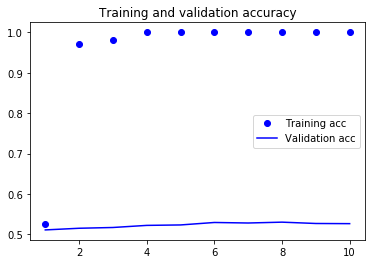

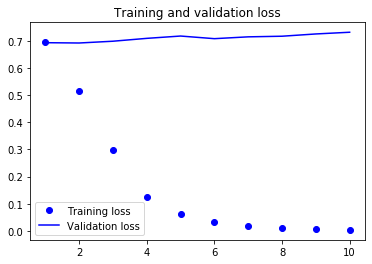

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The neural network that doesn't use the pretrained embedding performs marginally worse.

We can also evaluate the model performance on test data. First lets tokenize the test data.

In [23]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

We can then evaluate the pretrained model.

In [24]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 21us/step


[0.7673048898983001, 0.5695199966430664]

Model does badly on just a few data points.